<a href="https://colab.research.google.com/gist/tyty9798123/f302c49c7154e98c52067822e08ede89/experiment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import packages

In [ ]:
import numpy as np
import pandas as pd
import os

import time
import datetime
import glob

import warnings
warnings.filterwarnings("ignore")

from pandas.core.frame import DataFrame
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.rcParams["figure.dpi"] = 300
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import ClusterCentroids
from sklearn.ensemble import BaggingClassifier

import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Data Preprocessing

## Change Time Zone

In [ ]:
!date -R
os.environ["TZ"] = "America/New_York"
time.tzset()
!date -R

Fri, 06 Jan 2023 15:28:18 +0000
Fri, 06 Jan 2023 10:28:18 -0500


## Load Data

In [ ]:
dir = './drive/MyDrive/stocktwits_dataset'
symbol = 'SPY'
my_dir = os.path.join(dir, symbol)

In [ ]:
saved_path = os.path.join(my_dir, symbol+'_Finbert_processed.csv') # read machine-labeled and user-labeled
df = pd.read_csv(saved_path)

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Sentence,Timestamp,DateTime,Sentiment
0,0,25,cashtag_SPY watching squawk box im losing brai...,1584964231000,2020/03/23 07:50:31,neutral
1,1,24,cashtag_SPY there’s no cure,1584964276000,2020/03/23 07:51:16,neutral
2,2,22,cashtag_SPY cashtag_DJIA cashtag_AAPL cashtag_...,1584964278000,2020/03/23 07:51:18,negative
3,3,21,cashtag_SPY uh oh,1584964308000,2020/03/23 07:51:48,neutral
4,4,20,cashtag_TVIX Im in a NY hospital with my mom. ...,1584964331000,2020/03/23 07:52:11,neutral


## Load Historical Stock Data

In [ ]:
fin_dir = os.path.join('./drive/MyDrive/stocktwits_dataset', 'Financial', symbol+'.csv')
fin_df = pd.read_csv(fin_dir)
fin_df.head()

,Date,Open,High,Low,Close,VWAP,Volume,Change Percent,Change,Trade Value
0,2022-05-31,411.7713,414.6688,408.2665,411.1540,411.4038,95718004,-0.561,-2.3200,39554271900
1,2022-05-27,406.1556,413.5935,405.9465,413.4740,410.7660,84653856,2.455,9.9072,34898718400
2,2022-05-26,396.9553,405.2893,396.7363,403.5668,402.7934,81933455,1.998,7.9059,33104555200
3,2022-05-25,390.6227,397.7320,390.2045,395.6609,394.1357,91225026,0.883,3.4650,36106475400
4,2022-05-24,390.8716,393.4505,385.2957,392.1959,389.3216,91251910,-0.763,-3.0170,35712086900


## Load Historcial Stock Price (Intraday)

In [ ]:
# intraday stock price (15 mins update)
path_15mins = './drive/MyDrive/stocktwits_dataset/fifteen_mins/' + symbol
all_files = glob.glob(
    os.path.join(path_15mins, '*.csv')
)
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

fifteen_mins_df = pd.concat(li, axis=0, ignore_index=True)
fifteen_mins_df = fifteen_mins_df.drop_duplicates(subset=['time'])
# Divide DateTime
Dates = []
Times = []
for index, row in fifteen_mins_df.iterrows():
  Dates.append(
      row["time"].split(" ")[0]
  )
  Times.append(
      row["time"].split(" ")[1]
  )
fifteen_mins_df["Date"] = Dates
fifteen_mins_df["Time"] = Times
fifteen_mins_df = fifteen_mins_df.drop(columns=['time'])
fifteen_mins_df.head()

,open,high,low,close,volume,Date,Time
0,444.0500,444.06,443.67,443.70,40553,2022-03-21,20:00:00
1,444.2500,444.25,444.00,444.08,25414,2022-03-21,19:45:00
2,444.1100,444.25,444.08,444.25,13807,2022-03-21,19:30:00
3,444.3100,444.34,444.10,444.10,47152,2022-03-21,19:15:00
4,444.4799,444.49,444.30,444.33,6928,2022-03-21,19:00:00


## Add Column Open Timestamp

In [ ]:
# Open Timestamp is the timestamp at open(9:30 AM)
Open_Timestamp = []
for i in range(len(fin_df)):
    temp = time.mktime(datetime.datetime.strptime(fin_df["Date"][i], "%Y-%m-%d").timetuple()) + (9.5*60*60)
    Open_Timestamp.append(int(temp))
fin_df["Open Timestamp"] = Open_Timestamp
fin_df.head()

## Keey Only Date, Open Timestamp, Change Percent

In [ ]:
fin_tmp_df = DataFrame()
fin_tmp_df["Date"] = fin_df["Date"]
fin_tmp_df["Open Timestamp"] = fin_df["Open Timestamp"]
fin_tmp_df["Change Percent"] = fin_df["Change Percent"]
fin_tmp_df.head()

## Get Sentiment Index

In [ ]:
def get_sentiment_index_three_class(concated, timestamp, hour_1, hour_2):
  open_timestamp = timestamp
  filter1 = concated['Timestamp'] < (open_timestamp - hour_1 *(60*60) ) * 1000 #小於Open
  filter2 = concated["Timestamp"] > (open_timestamp - hour_2 *(60*60) ) * 1000 #大於Open - 43200(12小時前)
  concated = concated.where(filter1 & filter2)
  tmp = concated.dropna(subset=["Timestamp"])
  p = tmp.where( tmp['Sentiment'] == 'positive' )
  p = p.dropna(subset=["Timestamp"])
  
  neg = tmp.where( tmp['Sentiment'] == 'negative' )
  neg = neg.dropna(subset=["Timestamp"])

  neu = tmp.where( tmp['Sentiment'] == 'neutral' )
  neu = neu.dropna(subset=["Timestamp"])

  num_of_positive = p.count()["Sentiment"]
  num_of_negative = neg.count()["Sentiment"]
  num_of_neutral = neu.count()["Sentiment"]

  return (num_of_positive - num_of_negative) / (num_of_positive + num_of_negative + num_of_neutral)

## Get Previous Financial Data

In [ ]:
def getPrevFinancialData(Date):
  current_index = fin_df.where(fin_df["Date"] == Date).dropna(subset=["Date"]).index[0]
  prev_index = current_index + 1
  return fin_df.iloc[prev_index]

In [ ]:
def getPrevFinancialDataWithDay(Date, num_of_days):
  current_index = fin_df.where(fin_df["Date"] == Date).dropna(subset=["Date"]).index[0]
  prev_index = current_index + num_of_days
  return fin_df.iloc[prev_index]

## Function of Get Percentage Change

In [ ]:
def get_percentage_change_with_mins(date, time):
  tmp = fifteen_mins_df[(fifteen_mins_df.Date == date) & (fifteen_mins_df.Time == time)]
  tmp = tmp.dropna(subset=["Time"])
  tmp['open'] = tmp['open'].apply(lambda x: float(x))
  tmp['high'] = tmp['high'].apply(lambda x: float(x))
  tmp['low'] = tmp['low'].apply(lambda x: float(x))
  tmp['close'] = tmp['close'].apply(lambda x: float(x))

  return tmp

In [ ]:
float( get_percentage_change_with_mins('2022-02-15', "16:00:00")["close"] )

NameError: ignored

In [ ]:
def split(word):
    return [char for char in word]

In [ ]:
time = "1200"
num = 14
generated_file_name = f'processed_2020_with_{time}_{num}.csv'
print(generated_file_name)

processed_2020_with_1200_14.csv



## Generate the data Before training.

In [ ]:
dataset = DataFrame()
concat_path = saved_path
concated = pd.read_csv(concat_path)

#Features
positive_percent_pre_market = [] #04:00~9:30 0, 5.5
positive_percent_55_95 = [] #00:00~04:00
positive_percent_95_135 = [] #20:00~00:00
positive_percent_after_market = [] #16:00~20:00
positive_percent_55_135 = []
positive_percent_yesterday_market = []
positive_percent_the_day_before_yesterday = []
positive_sum_pre_market = []
negative_sum_pre_market = []

positive_sum_55_95 = []
negative_sum_55_95 = []

positive_sum_95_135 = []
negative_sum_95_135 = []

positive_sum_after_market = []
negative_sum_after_market = []

positive_sum_yesterday_market = []
negative_sum_yesterday_market = []

sentiment_number_24hr = []
dates = []

prev_open = []
prev_high = []
prev_low =[]
prev_close = []
prev_volume = []
prev_change_percent = []
prev_vwap = []
prev_trade_value = []
prev_hlpct = []
today_open = []
day_of_the_week = []
premarkets = []
percentage_change = []
for index, row in fin_tmp_df.iterrows():
  timestamp = row['Open Timestamp']# + 2 * 60 * 60
  print(row["Date"])
  print(index+1)
  try:

    open = float(get_percentage_change_with_mins(row["Date"], "09:30:00")['close'])
    close = float(get_percentage_change_with_mins(row["Date"], 
         f"{split(time)[0]}{split(time)[1]}:{split(time)[2]}{split(time)[3]}:00")['close'])
  except:
    print("error")
    break
  # 星期幾欄位
  
  temp = pd.Timestamp(row["Date"])
  day_of_the_week.append(int(temp.dayofweek+1))
  dates.append(
      row["Date"]
  )
  # Positive Percent
  positive_percent_pre_market.append(
      get_sentiment_index_three_class(concated, timestamp, 0, 5.5) #0~5.5為正常
  )
  positive_percent_55_95.append(
      get_sentiment_index_three_class(concated, timestamp, 5.5, 9.5)
  )

  positive_percent_95_135.append(
      get_sentiment_index_three_class(concated, timestamp, 9.5, 13.5)
  )
  positive_percent_55_135.append(
      get_sentiment_index_three_class(concated, timestamp, 5.5, 13.5)
  )
  
  positive_percent_after_market.append(
      get_sentiment_index_three_class(concated, timestamp, 13.5, 17.5)
  )
  positive_percent_yesterday_market.append(
      get_sentiment_index_three_class(concated, timestamp, 17.5, 24)
  )
  positive_percent_the_day_before_yesterday.append(
      get_sentiment_index_three_class(concated, timestamp, 24, 48)
  )
  """
  sentiment_number_24hr.append(
      getSentimentSum(concated, timestamp, 0, 24)[0] + getSentimentSum(concated, timestamp, 0, 24)[1]
  )"""

  # Previous Day Data
  prev_open.append(
      getPrevFinancialData(row["Date"])["Open"]
  )
  prev_high.append(
      getPrevFinancialData(row["Date"])["High"]
  )
  prev_low.append(
      getPrevFinancialData(row["Date"])["Low"]
  )
  prev_close.append(
      getPrevFinancialData(row["Date"])["Close"]
  )
  prev_hlpct.append(
      (getPrevFinancialData(row["Date"])["High"] - getPrevFinancialData(row["Date"])["Low"]) / getPrevFinancialData(row["Date"])["Low"]
  )
  prev_volume.append(
      getPrevFinancialData(row["Date"])["Volume"]
  )
  
  prev_change_percent.append(
      ( getPrevFinancialData(row["Date"])["Close"] - getPrevFinancialData(row["Date"])["Open"] ) / getPrevFinancialData(row["Date"])["Open"]
      #getPrevFinancialData(row["Date"])["Change Percent"]
  )
  prev_vwap.append(
      getPrevFinancialData(row["Date"])["VWAP"]
  )
  prev_trade_value.append(
      getPrevFinancialData(row["Date"])["Trade Value"]
  )
  # Label
  percentage_change.append(
      ( close - open ) / open
  )
  print("totally appended")
# Features
dataset["Date"] = dates
dataset["day_of_the_week"] = day_of_the_week
dataset["positive_percent_pre_market"] = positive_percent_pre_market
dataset["positive_percent_55_135"] = positive_percent_55_135
dataset["positive_percent_55_95"] = positive_percent_55_95
dataset["positive_percent_95_135"] = positive_percent_95_135
dataset["positive_percent_after_market"] = positive_percent_after_market
dataset["positive_percent_yesterday_market"] = positive_percent_yesterday_market
dataset['positive_percent_the_day_before_yesterday'] = positive_percent_the_day_before_yesterday

#dataset["sentiment_number_24hr"] = sentiment_number_24hr

dataset["Prev Open"] = prev_open
dataset["Prev Close"] = prev_close
dataset["Prev High"] = prev_high
dataset["Prev Low"] = prev_low
dataset["Prev HLPCT"] = prev_hlpct
dataset["Prev Volume"] = prev_volume
dataset["Prev Change Percent"] = prev_change_percent
dataset["Prev Trade Value"] = prev_trade_value
dataset["Prev VWAP"] = prev_vwap
#dataset["Premarket Changed"] = premarkets
# Label
dataset["percentage_change"] = percentage_change

# 刪除有0或是空的列
print(dataset)

processed_path = os.path.join('./drive/MyDrive/stocktwits_dataset', symbol, generated_file_name)
dataset.to_csv(processed_path)

KeyboardInterrupt: ignored

In [ ]:
processed_path = os.path.join('./drive/MyDrive/stocktwits_dataset', symbol, generated_file_name)
print(processed_path)

dataset = pd.read_csv(processed_path)
"""
dataset = dataset.drop(
    [
     'positive_percent_95_115',
     'positive_percent_115_135'
    ],
    axis=1
)"""
# Dele
dataset = dataset.drop(
    [
     #'sentiment_number_24hr',
     #'positive_percent_yesterday_market',
     #'Prev Open',
     #'Prev Close',
     #'Prev High',
     #'positive_percent_the_day_before_yesterday', #c
     #'Prev Low',
     #'Prev Volume',
     #'Prev Trade Value',
     'Prev VWAP',#c
     #'positive_percent_pre_market',
     'positive_percent_55_95',
     'positive_percent_55_135',
     'positive_percent_the_day_before_yesterday',
     'positive_percent_95_135',
     #'positive_percent_after_market',
     #'positive_percent_yesterday_market',
     'Prev HLPCT',#c
     #'Premarket Changed'
     #'positive_percent_55_135'#c,



     #"positive_percent_pre_market",
     #"positive_percent_after_market",
     #"positive_percent_yesterday_market"
    ],
    axis=1
)


dataset = dataset.drop(
    [
     'Unnamed: 0',
     #'day_of_the_week',
    ],
    axis=1
)
dataset["percentage_change"] = dataset["percentage_change"] * 100


days_of_week = pd.get_dummies(dataset.day_of_the_week)
dataset = pd.concat([dataset, days_of_week], axis=1)
temp_percentage_change = dataset["percentage_change"]
dataset = dataset.drop(["percentage_change"], axis=1)
dataset["percentage_change"] = temp_percentage_change
dataset = dataset.drop(['day_of_the_week'], axis=1)
dataset = dataset.drop(
    [
     1, 
     2, 
     3, 
     4, 
     5
    ],
    axis=1
)
end_index = dataset[dataset['Date']=='2022-02-28'].index[0]
start_testing_index = (len(dataset.index) - dataset[dataset['Date']=='2021-04-05'].index[0]) - 1
dataset = dataset[end_index:]
dataset = dataset.iloc[::-1]
print("End Index", end_index)
print("Start Testing Index", start_testing_index)
dataset

./drive/MyDrive/stocktwits_dataset/SPY/processed_2020_with_1200_14.csv
End Index 5
Start Testing Index 253


,Date,positive_percent_pre_market,positive_percent_after_market,positive_percent_yesterday_market,Prev Open,Prev Close,Prev High,Prev Low,Prev Volume,Prev Change Percent,Prev Trade Value,percentage_change
486,2020-04-01,-0.134855,-0.134700,-0.145378,253.9005,251.1623,256.5997,249.6715,193290928,-0.010785,49731996200,0.322646
485,2020-04-02,-0.198980,-0.140897,-0.142982,241.6421,239.8588,251.0738,237.6663,188373330,-0.007380,46454886300,2.281811
484,2020-04-03,-0.189400,-0.128052,-0.151454,238.9234,245.3937,246.2219,238.3387,176669824,0.027081,43613280900,-1.006222
483,2020-04-06,-0.115970,-0.143818,-0.181747,244.3510,241.8467,246.8456,238.9526,134538553,-0.010249,33050036600,1.147776
482,2020-04-07,-0.101322,-0.102104,-0.116928,251.2500,258.0906,260.1759,241.8270,186692564,0.027226,48044974900,-1.000146
...,...,...,...,...,...,...,...,...,...,...,...,...
9,2022-02-22,-0.127823,-0.136974,-0.167445,437.3300,434.2300,438.6600,431.8200,132414754,-0.007088,57720378000,-0.159655
8,2022-02-23,-0.123596,-0.119155,-0.109571,431.8900,429.5700,435.5000,425.8600,124054581,-0.005372,53384444100,-0.882972
7,2022-02-24,-0.153915,-0.144759,-0.135680,432.6600,421.9500,433.2600,421.3500,131884132,-0.024754,56332708600,1.861133
6,2022-02-25,-0.107367,-0.108611,-0.112070,411.0200,428.3000,428.7600,410.6400,213444305,0.042042,89499945200,1.659722


# Traning

In [ ]:
dataset.drop(["Date"], inplace=True, axis=1)
X, y = np.hsplit( dataset.to_numpy(), [-1])
_y = np.array(y>=0, dtype=int)

## Rolling Window

In [ ]:
def movement_data(X, y, current, n):
  #X_train = X[:current]
  #y_train = y[:current]
  X_train = X[current-n:current]
  y_train = y[current-n:current]
  
  X_test = X[current]
  y_test = y[current]
  return (X_train, np.array([X_test]), y_train, np.array([y_test]))

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import RobustScaler

history = []
history_w = []
history_score = []
range__ = [i for i in range(232, start_testing_index+1) if i % 2 == 0]

best_score = 0
best_n = 0
print(range__)
pred_his = []
c = 1
g = 'scale'
for i in range__:
  n=i
  score = 0
  count = 0
  preds = []
  while(True):
    try:
      start_num = n + count
      print(start_num, n)
      
      X_train, X_test, y_train, y_test = movement_data(X, _y, start_num, n)
      X_train, y_train = SMOTE(random_state=0, k_neighbors=5, n_jobs=-1).fit_resample(X_train, y_train)
      #標準化
      #scaler = StandardScaler()
      scaler = RobustScaler()
      scaler.fit(X_train) 
      X_train = scaler.transform(X_train)
      X_test = scaler.transform(X_test)

      #訓練      
      bagging_clf = BaggingClassifier(
          SVC(C=c, gamma=g),
          n_estimators=100,
          bootstrap=True,
          oob_score=False,
          n_jobs=-1,
          random_state=0
      ).fit(X_train, y_train)
      #計算分數 0 or 1
      pred = bagging_clf.predict(X_test)[0]
      preds.append(pred)
      real = y_test[0][0]

      count+=1
      #答對
      if pred == real:
        score+=1
      #print("Score:", score)
      history.append(
          score / count
      )
      print(score / count)
    except:
      print("some exception occur")
      break
  pred_his.append(preds)
  if (score/count) > best_score:
    best_score = score/count
    best_n = n
    best_c = c
    best_g = g
  history_w.append(n)
  history_score.append(score / count)
  print("N:", n)
  print("Current Accuracy:", score / count)
  print("Best N:", best_n)
  print("Best Score:", best_score)

串流輸出內容已截斷至最後 5000 行。
405 232
0.5919540229885057
406 232
0.5942857142857143
407 232
0.5965909090909091
408 232
0.5932203389830508
409 232
0.5955056179775281
410 232
0.5977653631284916
411 232
0.6
412 232
0.6022099447513812
413 232
0.5989010989010989
414 232
0.6010928961748634
415 232
0.6032608695652174
416 232
0.6054054054054054
417 232
0.6075268817204301
418 232
0.6042780748663101
419 232
0.6063829787234043
420 232
0.6031746031746031
421 232
0.6052631578947368
422 232
0.6073298429319371
423 232
0.6041666666666666
424 232
0.6062176165803109
425 232
0.6082474226804123
426 232
0.6051282051282051
427 232
0.6020408163265306
428 232
0.6040609137055838
429 232
0.6060606060606061
430 232
0.6080402010050251
431 232
0.61
432 232
0.6069651741293532
433 232
0.6089108910891089
434 232
0.6108374384236454
435 232
0.6078431372549019
436 232
0.6097560975609756
437 232
0.6116504854368932
438 232
0.6135265700483091
439 232
0.6153846153846154
440 232
0.6172248803827751
441 232
0.6142857142857143
442 232
0

In [ ]:
pred_his =  np.array(pred_his)

f1_scores = []
for his in pred_his:
  labels = _y[start_testing_index:]
  preds = his[-(len(dataset)-start_testing_index):]
  #print( confusion_matrix(labels, preds) )
  #print( "Accuracy Score:", accuracy_score(labels, preds) )
  #print( "Precision。Score:", precision_score(labels, preds) )
  #print( "Recall Score:", recall_score(labels, preds) )
  print( "F1 Score:", f1_score(labels, preds) )
  f1_scores.append(f1_score(labels, preds))

F1 Score: 0.636734693877551
F1 Score: 0.610878661087866
F1 Score: 0.631578947368421
F1 Score: 0.6530612244897959
F1 Score: 0.6141078838174274
F1 Score: 0.5787234042553192
F1 Score: 0.5948275862068966
F1 Score: 0.6297872340425532
F1 Score: 0.5833333333333334
F1 Score: 0.6016949152542374
F1 Score: 0.5991561181434599


In [ ]:
sum(f1_scores) / len(f1_scores)

0.6121712728978964

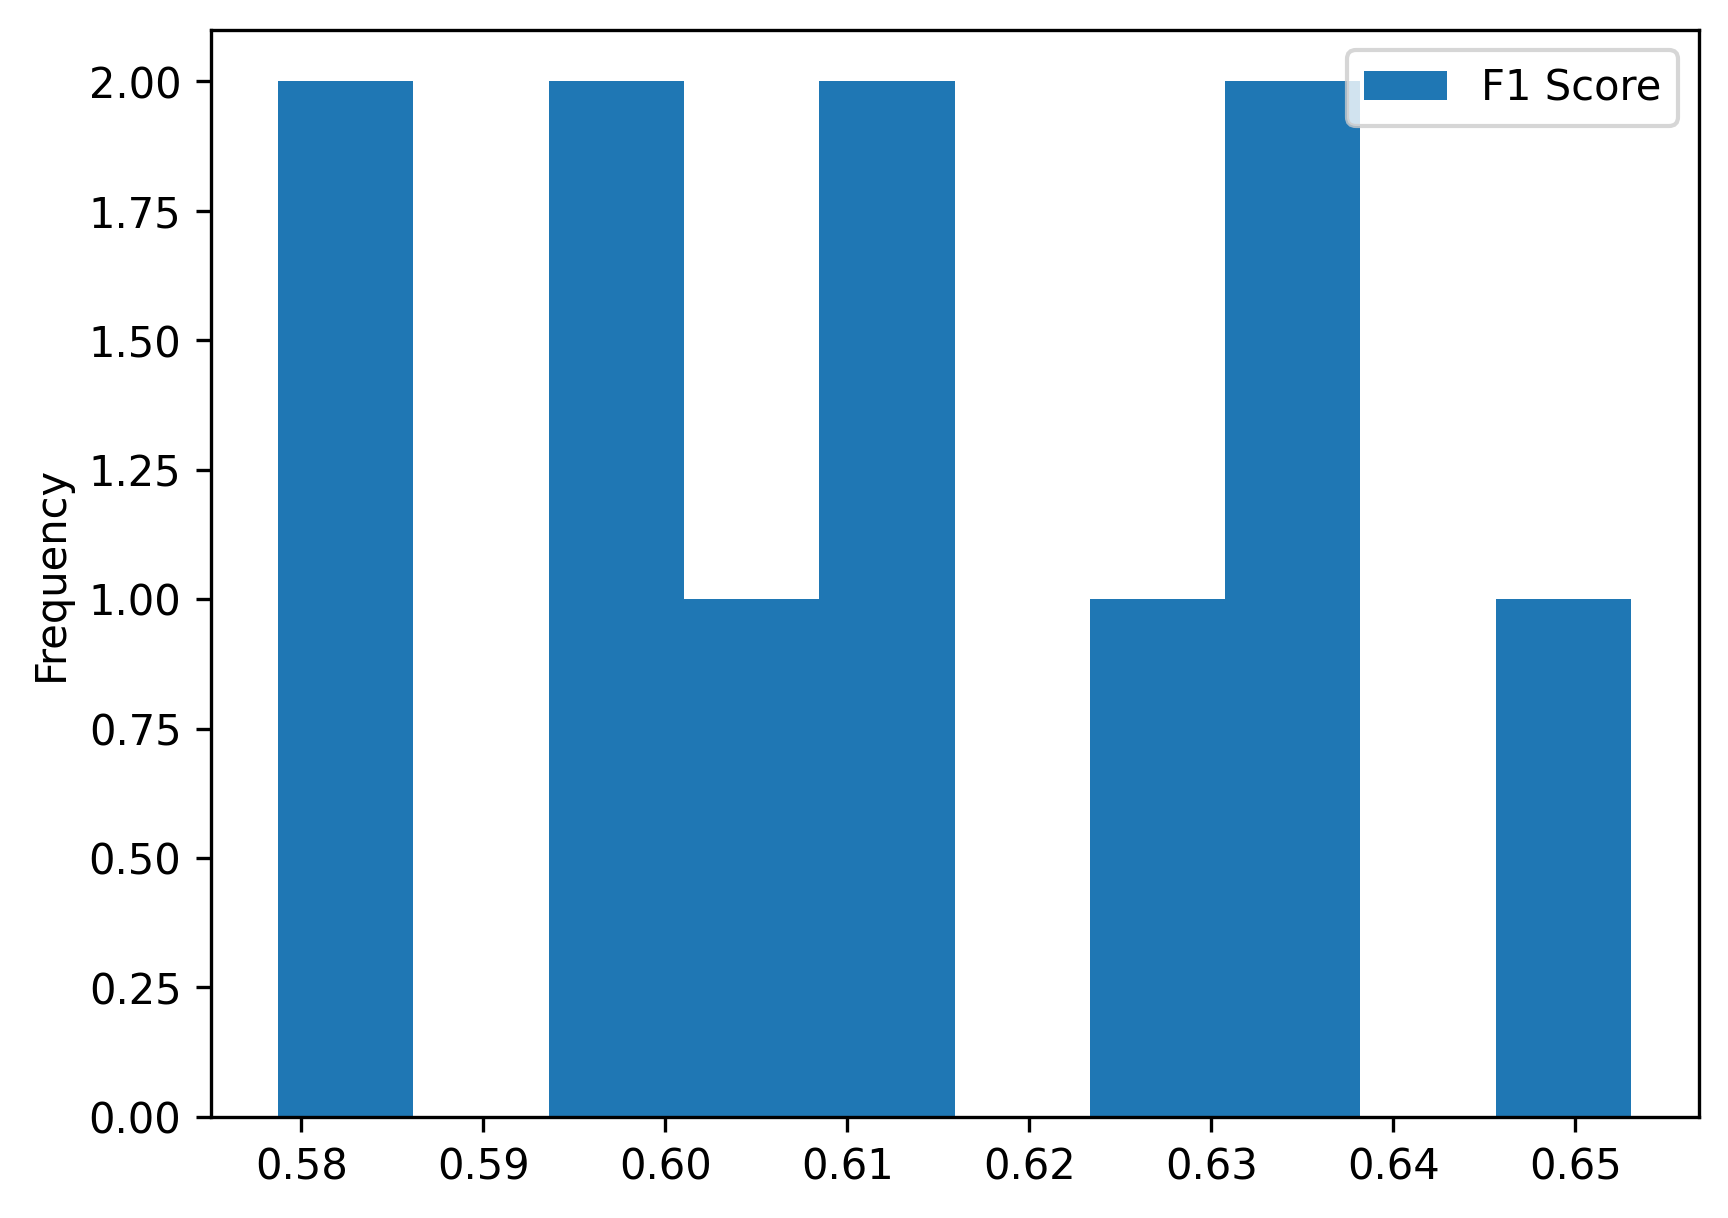

In [ ]:
d = pd.DataFrame()
d["Window Size"] = [str(i) for i in range__]
d["F1 Score"] = f1_scores
d.plot(x="Window Size", y="F1 Score", kind="hist") 

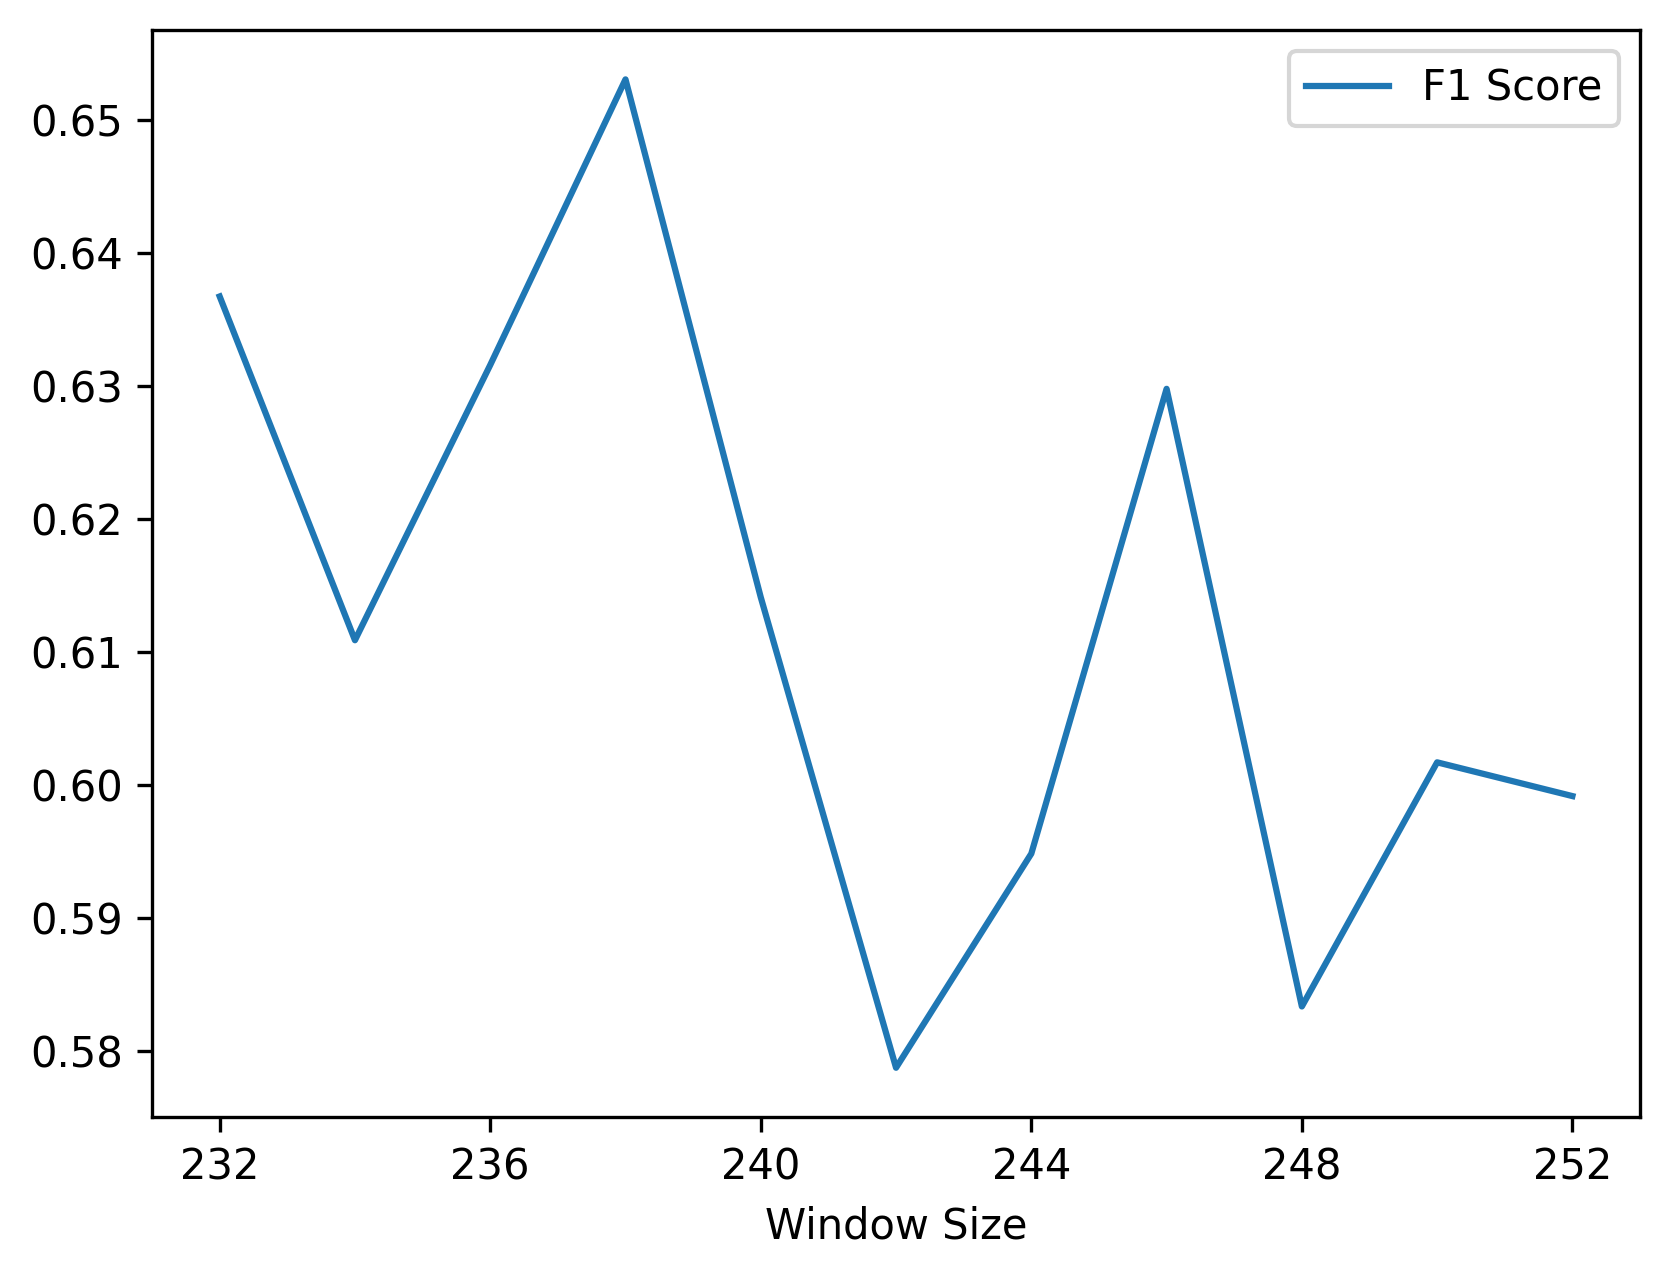

In [ ]:
d.plot(x="Window Size", y="F1 Score", kind="line") 

## Confusion Matrix

In [ ]:
start = start_testing_index
_y = _y[start:]
preds = preds[- ( len(X) - start ):]
print( confusion_matrix(_y, preds) )
print( "Accuracy Score:", accuracy_score(_y, preds) )
print( "Precision Score:", precision_score(_y, preds) )
print( "Recall Score:", recall_score(_y, preds) )
print( "F1 Score:", f1_score(_y, preds) )

ValueError: ignored